In [1]:
import sys
import subprocess

print("Python executable:", sys.executable)

subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "openpyxl"])


Python executable: C:\Users\josef\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe


0

In [2]:
import openai
from openai import OpenAI

print(openai.__version__)




2.8.1


In [3]:
#import pandas as pd
#import matplotlib.pyplot as plt
#from vllm import LLM, SamplingParams
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:8000/v1",
    api_key="not-needed" 
)

MODEL_NAME = "Qwen2-0.5B-Instruct" 

In [4]:
import pandas as pd

df = pd.read_excel("./testdata_MIE.xlsx")
df.to_csv("./testdata_MIE.csv", index=False)

df.head()


,PatientAccountID,MPINumber,AssessmentID,Source,CollectedDT,Finding,FindingName,FindingDataType,Value,AdditionalInformation
0,NaN,P-5xxxxxxxx,NaN,Stammdaten,Jul xx 20xx xx:xxAM,Geburtsdatum,NaN,9,xx/19xx,NaN
1,NaN,P-5xxxxxxxx,NaN,Stammdaten,Jun xx 20xx xx:xxPM,Geschlecht,NaN,1,männlich,NaN
2,P-8xxxxxxxxx,P-5xxxxxxxx,NaN,Diagnosen,Jun xx 20xx xx:xxAM,Diagnose,NaN,1,N18.0,Terminale Niereninsuffizienz
3,P-8xxxxxxxxx,P-5xxxxxxxx,NaN,Diagnosen,Jun xx 20xx xx:xxPM,Diagnose,NaN,1,G63.2*,Diabetische Polyneuropathie
4,P-8xxxxxxxxx,P-5xxxxxxxx,NaN,Diagnosen,Jun xx 20xx xx:xxPM,Diagnose,NaN,1,H36.0*,Retinopathia diabetica


In [5]:
messages = [
    {"role": "user", "content": "Say hello from the Qwen server in one short sentence."}
]

response = client.chat.completions.create(
    model="Qwen/Qwen2-0.5B-Instruct",  
    messages=messages,
    temperature=0.1,
    max_tokens=100,
)

print(response.choices[0].message.content)




Hello from the Qwen server.


In [54]:
from typing import List
import pandas as pd

def build_messages_for_query(df: pd.DataFrame, query: str) -> List[dict]:
    columns = list(df.columns)
    columns_str = ", ".join(columns)

    system_content = (
        "You write pure Python code to analyze an existing pandas DataFrame named df.\n"
        "df is already loaded in memory.\n"
        "\n"
        "HARD RULES:\n"
        "- NEVER load files (no pd.read_csv, no file paths).\n"
        "- NEVER write your_file.csv it should always be testdata_MIE.csv if you have to write it\n"
        "- ANY occurrence of 'read_csv' in your output is INVALID.\n"
        "- NEVER overwrite df or assign a new object to df.\n"
        "- If loading appears necessary, output only:\n"
        "    raise ValueError('Loading files is forbidden because df is already provided.')\n"
        "- Use ONLY existing columns: " + columns_str + "\n"
        "- If required columns are missing, use the pattern:\n"
        "    required = {...}\n"
        "    missing = required.difference(df.columns)\n"
        "    if missing:\n"
        "        raise ValueError(f'Missing required columns: {missing}')\n"
        "\n"
        "SEMANTICS:\n"
        "- Diagnoses: Finding == 'Diagnose', diagnosis code is stored in 'Value'.\n"
        "- Gender: check 'Gender' or 'Geschlecht'. If neither exists, raise ValueError.\n"
        "- Secondary diagnoses: use rows where Finding == 'Diagnose', count Value, take top 5.\n"
        "- HBA1C: rows where Finding contains 'HBA1C' (case-insensitive). Value contains the measurement.\n"
        "- For HBA1C per diagnosed patient:\n"
        "    1) Find diagnosed patients.\n"
        "    2) Select HBA1C rows among them.\n"
        "    3) Group by MPINumber and count.\n"
        "\n"
        "OUTPUT FORMAT:\n"
        "- Output ONLY Python code, no comments, no text.\n"
        "- Always print results or show plots.\n"
        "- For plots: import matplotlib.pyplot as plt and end with plt.tight_layout() and plt.show().\n"
    )

    # Example 1: Gender
    example_user_1 = "Example: Create a pie chart of Gender distribution."
    example_assistant_1 = (
        "import matplotlib.pyplot as plt\n"
        "if 'Gender' not in df.columns and 'Geschlecht' not in df.columns:\n"
        "    raise ValueError(\"The dataset does not contain a gender column ('Gender' or 'Geschlecht').\")\n"
        "col = 'Gender' if 'Gender' in df.columns else 'Geschlecht'\n"
        "counts = df[col].value_counts()\n"
        "plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')\n"
        "plt.tight_layout()\n"
        "plt.show()"
    )

    # Example 2: N18 diagnosis
    example_user_2 = "Example: How many patients got diagnosed with N18?"
    example_assistant_2 = (
        "required = {'Finding', 'Value', 'MPINumber'}\n"
        "missing = required.difference(df.columns)\n"
        "if missing:\n"
        "    raise ValueError(f'Missing required columns: {missing}')\n"
        "mask = (df['Finding'] == 'Diagnose') & df['Value'].str.contains('N18', na=False)\n"
        "subset = df.loc[mask]\n"
        "n_patients = subset['MPINumber'].nunique()\n"
        "print('Number of patients diagnosed with N18:', n_patients)"
    )

    # Example 3: Secondary diagnoses
    example_user_3 = "Example: Plot the five most common secondary diagnoses."
    example_assistant_3 = (
        "import matplotlib.pyplot as plt\n"
        "required = {'Finding', 'Value'}\n"
        "missing = required.difference(df.columns)\n"
        "if missing:\n"
        "    raise ValueError(f'Missing required columns: {missing}')\n"
        "mask = df['Finding'] == 'Diagnose'\n"
        "subset = df.loc[mask]\n"
        "counts = subset['Value'].value_counts().head(5)\n"
        "counts.plot(kind='bar')\n"
        "plt.tight_layout()\n"
        "plt.show()"
    )

    # Example 4: HBA1C
    #example_user_4 = "Example: How many HBA1C values does each diagnosed patient have?"
    #example_assistant_4 = (
    #    "required = {'Finding', 'Value', 'MPINumber'}\n"
    #    "missing = required.difference(df.columns)\n"
    #    "if missing:\n"
    #    "    raise ValueError(f'Missing required columns: {missing}')\n"
    #    "diag_patients = df.loc[df['Finding'] == 'Diagnose', 'MPINumber'].unique()\n"
    #    "mask_hba1c = df['Finding'].str.contains('HBA1C', case=False, na=False)\n"
    #    "subset = df.loc[mask_hba1c & df['MPINumber'].isin(diag_patients)]\n"
    #    "counts = subset.groupby('MPINumber').size()\n"
    #    "print(counts)"
    #)

    real_user = f"Task: {query}"

    return [
        {"role": "system", "content": system_content},

        {"role": "user", "content": example_user_1},
        {"role": "assistant", "content": example_assistant_1},

        {"role": "user", "content": example_user_2},
        {"role": "assistant", "content": example_assistant_2},

        {"role": "user", "content": example_user_3},
        {"role": "assistant", "content": example_assistant_3},

        #
        #{"role": "user", "content": example_user_4},
        #{"role": "assistant", "content": example_assistant_4},

        # Real query at the very end
        {"role": "user", "content": real_user},
    ]



def ask_llm(df: pd.DataFrame, query: str) -> str:
    """
    Schickt die Messages an den Qwen-Server und gibt den Code der Antwort zurück.
    Erwartung: reine Python-Code-Antwort, direkt mit exec() ausführbar.
    """
    messages = build_messages_for_query(df, query)

    response = client.chat.completions.create(
        model="Qwen/Qwen2-0.5B-Instruct",
        messages=messages,
        temperature=0.0,
        max_tokens=350, 
    )

    return response.choices[0].message.content



## RQ - A
How many people got diagnosed with H36 over time?

In [55]:
query = "How many patients got diagnosed with H36? Consider that each patient can have multiple findings."
response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)


Output:
required = {'Finding', 'Value', 'MPINumber'}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f'Missing required columns: {missing}')
mask = (df['Finding'] == 'H36') & df['Value'].str.contains('H36', na=False)
subset = df.loc[mask]
n_patients = subset['MPINumber'].nunique()
print('Number of patients diagnosed with H36:', n_patients)
#########
Number of patients diagnosed with H36: 0


## RQ - B
How was the age and gender distribution of the disease?

In [51]:
query = "Given the dataframe above, create a pie chart for the Gender distribution."

response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)


Output:
import matplotlib.pyplot as plt
if 'Gender' not in df.columns and 'Geschlecht' not in df.columns:
    raise ValueError("The dataset does not contain a gender column ('Gender' or 'Geschlecht').")
col = 'Gender' if 'Gender' in df.columns else 'Geschlecht'
counts = df[col].value_counts()
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
plt.tight_layout()
plt.show()
#########
Error while executing LLM-generated code: The dataset does not contain a gender column ('Gender' or 'Geschlecht').


## RQ - C
What were the five most common secondary diagnoses?

Output:
import matplotlib.pyplot as plt
required = {'Finding', 'Value'}
missing = required.difference(df.columns)
if missing:
    raise ValueError(f'Missing required columns: {missing}')
mask = df['Finding'] == 'Diagnose'
subset = df.loc[mask]
counts = subset['Value'].value_counts().head(5)
counts.plot(kind='bar')
plt.tight_layout()
plt.show()
#########


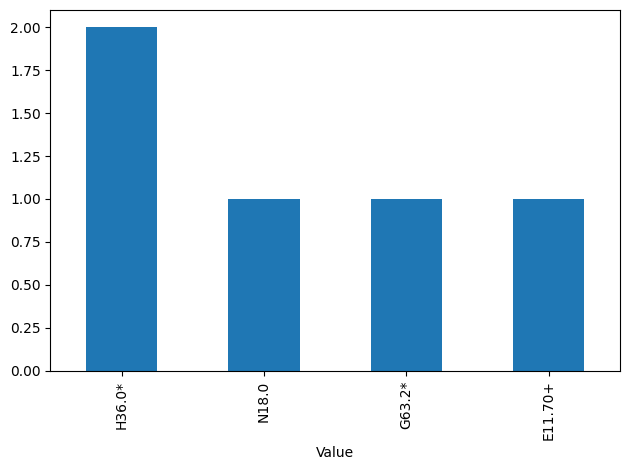

In [52]:
query = "Plot the five most common secondary diagnoses."

response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)


## RQ - D
How many HBA1C values are there for each patient?

In [56]:

query = "How many the HBA1C values has each diagnosed patient?"

response_text = ask_llm(df, query)

print("Output:")
print(response_text)
print("#########")

try:
    exec(response_text)
except Exception as e:
    print("Error while executing LLM-generated code:", e)

Output:
import pandas as pd
df = pd.read_csv('testdata_MIE.csv')
df['HBA1C'] = df['HBA1C'].str.lower()
df['HBA1C'].value_counts().plot(kind='bar')
plt.tight_layout()
plt.show()
#########
Error while executing LLM-generated code: 'HBA1C'
